# Data Cleaning Validation — How Well Did We Clean the Data?

## 1. Introduction: What Are We Doing Here?

We have two versions of a dataset:
- **The original** (no errors, complete, clean)
- **Our restored version** (after cleaning a)

This notebook **compares these two versions** to see how well we did the restoration.

---

### The Context: Where We Started

**Starting point:**
- We had `energy_efficiency_modified.csv` that was **dirty** (errors, missing values, outliers, wrong types)
- We also had the **gold standard** `energy_efficiency_original.csv` to compare against

**What we did:**
- Applied a systematic cleaning process in notebooks 1.0 and 1.2:
  - Fixed missing values (filling strategy)
  - Corrected data types
  - Removed outliers (IQR method with 6×IQR multiplier)
  - Cleaned categorical variables (replaced rare categories with mode)
- Got `energy_efficiency_clean_fill.csv` as the result

**What we want to know:**
- How similar is our cleaned result to the original file?
- Did our cleaning process successfully restore the data quality?

---

### How We'll Measure Success

We'll compare **3 important aspects**:

1. **Data Quality** — How much data did we recover? Any missing values or duplicates?
2. **Statistical Characteristics** — Do the distributions match? Similar means and standard deviations?
3. **Model Performance** — Do models trained on both datasets perform similarly?

---

### What Do We Expect to Find?

If our cleaning was **successful**, we should see:
- **Both datasets clean** — No missing values, no obvious errors
- **Similar statistics** — Comparable means, standard deviations, and distributions
- **Similar model performance** — Both R² and MAE values should be close
- **High recovery rate** — We recovered most of the original rows (>90%)

**Goal:** Demonstrate that our cleaning process **effectively restored** the dirty data to match the original clean state as closely as possible.

---

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2) Load the Two Files to Compare

Here we load the two files we're going to compare:

**File 1: The Original**
- Name: `energy_efficiency_original.csv`
- This is our **gold standard** reference
- Has clean and correct data from the start

**📗 File 2: Our Cleaned Version**
- Name: `energy_efficiency_clean_fill.csv`
- This is the **result of our cleaning work**
- Started with dirty data and we cleaned it in previous notebooks

**Goal:** Verify that our cleaned file looks very similar to the perfect original file.

In [2]:
# Load ORIGINAL clean dataset (gold standard reference)
df_original = pd.read_csv('../data/raw/energy_efficiency_original.csv')

print("Original Clean Dataset (Gold Standard)")
print("=" * 60)
print(f"Shape: {df_original.shape}")
print(f"Missing values: {df_original.isna().sum().sum()}")
print(f"Duplicates: {df_original.duplicated().sum()}")
print("\nFirst rows:")
df_original.head()

Original Clean Dataset (Gold Standard)
Shape: (768, 10)
Missing values: 0
Duplicates: 0

First rows:


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
# Load OUR cleaned dataset (result of our cleaning pipeline)
df_clean = pd.read_csv('../data/processed/energy_efficiency_clean_fill.csv')
df_clean = df_clean.drop_duplicates(ignore_index=True) # This is in notebook 1.3

print("\nOur Cleaned Dataset (From Cleaning Pipeline)")
print("=" * 60)
print(f"Shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isna().sum().sum()}")
print(f"Duplicates: {df_clean.duplicated().sum()}")
print("\nFirst rows:")
df_clean.head()


Our Cleaned Dataset (From Cleaning Pipeline)
Shape: (721, 10)
Missing values: 0
Duplicates: 0

First rows:


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2.0,0.0,0.0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3.0,0.0,0.0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4.0,0.0,0.0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5.0,0.0,0.0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2.0,0.0,0.0,20.84,28.28


## 3) First Comparison: How Much Data Did We Recover?

Here we perform a **data quality assessment** to evaluate how well our cleaning worked.

**Metrics evaluated:**
- **Total rows** — How many observations does each dataset have?
- **Missing values** — Are there any gaps in the data?
- **Duplicates** — Is there any repeated data?
- **Recovery rate** — What percentage of the original rows did we successfully recover?

**What we're looking for:**
- High recovery rate (>90%) indicates effective cleaning without over-aggressive filtering
- Zero missing values in both datasets confirms data completeness
- Zero duplicates ensures data quality

In [4]:
comparison = pd.DataFrame({
    'Metric': ['Total Rows', 'Missing Values', 'Duplicates', 'Recovery Rate'],
    'Original (Gold)': [
        df_original.shape[0],
        df_original.isna().sum().sum(),
        df_original.duplicated().sum(),
        '100%'
    ],
    'Our Cleaned': [
        df_clean.shape[0],
        df_clean.isna().sum().sum(),
        df_clean.duplicated().sum(),
        f"{(df_clean.shape[0] / df_original.shape[0] * 100):.1f}%"
    ]
})

print("\nData Quality Comparison")
print("=" * 60)
display(comparison)

row_diff = df_original.shape[0] - df_clean.shape[0]
recovery_rate = (df_clean.shape[0] / df_original.shape[0] * 100)

print(f"\nData Recovery Analysis:")
print(f"   Original rows: {df_original.shape[0]}")
print(f"   Recovered rows: {df_clean.shape[0]}")
print(f"   Difference: {row_diff} rows ({100-recovery_rate:.1f}%)")

if recovery_rate >= 95:
    print(f" Excellent recovery rate: {recovery_rate:.1f}%")
elif recovery_rate >= 90:
    print(f"Good recovery rate: {recovery_rate:.1f}%")
else:
    print(f"Low recovery rate: {recovery_rate:.1f}% — May have removed too much data")


Data Quality Comparison


,Metric,Original (Gold),Our Cleaned
0,Total Rows,768,721
1,Missing Values,0,0
2,Duplicates,0,0
3,Recovery Rate,100%,93.9%



Data Recovery Analysis:
   Original rows: 768
   Recovered rows: 721
   Difference: 47 rows (6.1%)
Good recovery rate: 93.9%


## 4) Second Comparison: Do the Distributions Match?

Here we visually compare the **target variables** (Y1 and Y2) between both datasets.

**Target variables:**
- **Y1** — Heating Load (kWh/m²)
- **Y2** — Cooling Load (kWh/m²)

**What are we looking for?**
- **Similar histogram shapes** — Both distributions should have the same form
- **Aligned means** (dashed lines) — Averages should be in similar positions
- **Comparable spread** — Standard deviations should be similar
- **Similar skewness** — The direction and degree of asymmetry should match

**Interpretation:** If the distributions look nearly identical, it means our cleaning preserved the underlying data characteristics.

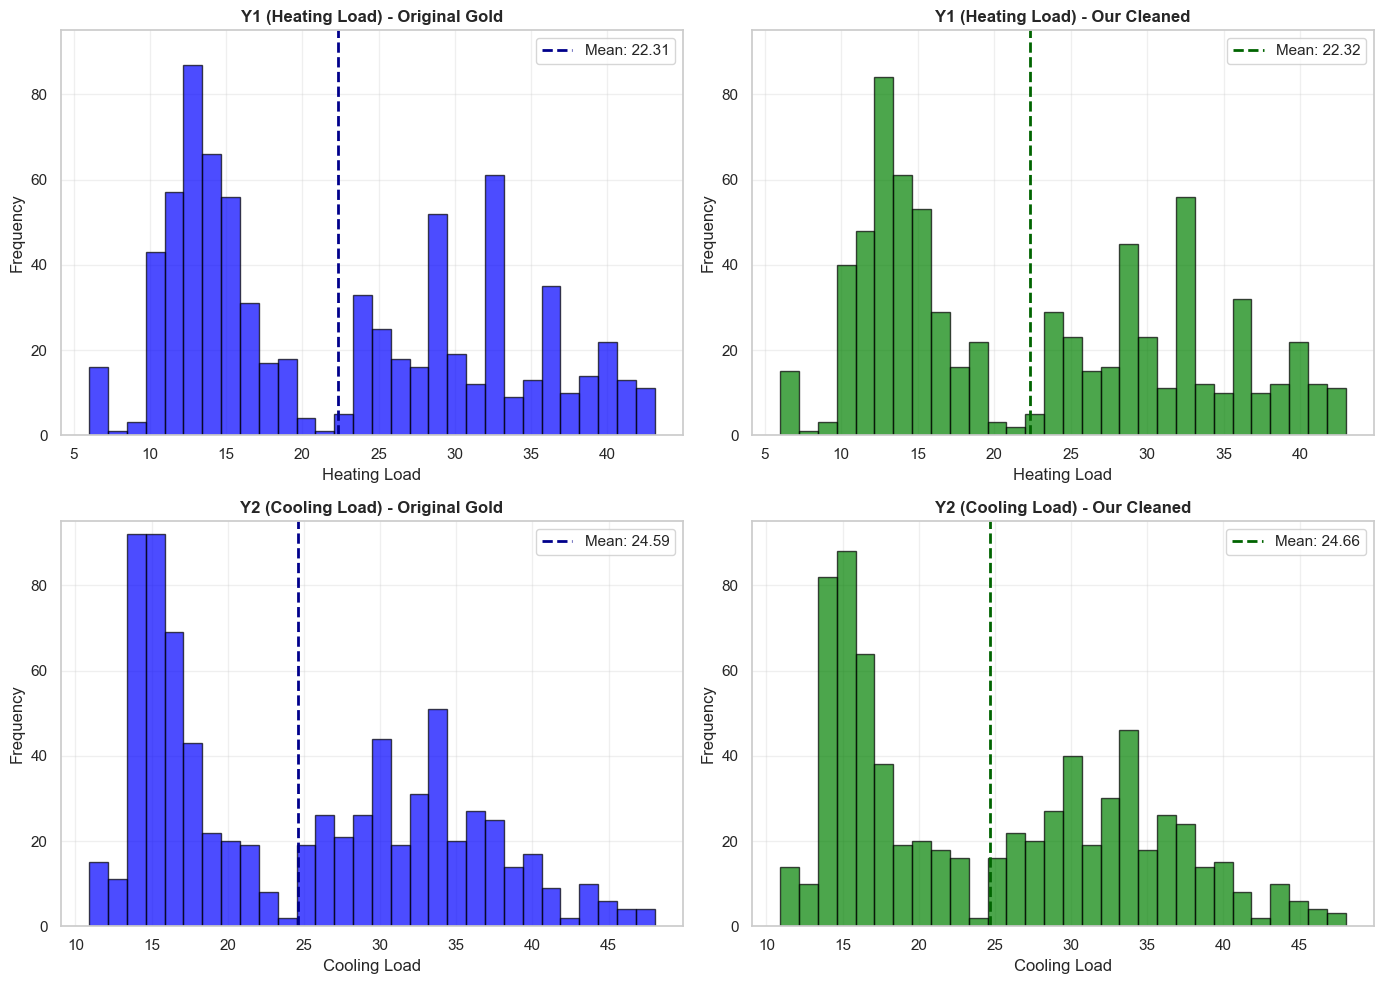


Statistical Comparison

Y1 (Heating Load):
  Original Gold: Mean=22.31, Std=10.09, Skew=0.36
  Our Cleaned:   Mean=22.32, Std=10.05, Skew=0.36
  Difference:    Mean=0.01, Std=0.04

Y2 (Cooling Load):
  Original Gold: Mean=24.59, Std=9.51, Skew=0.40
  Our Cleaned:   Mean=24.66, Std=9.47, Skew=0.39
  Difference:    Mean=0.07, Std=0.04


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Y1 Original (Gold)
axes[0, 0].hist(df_original['Y1'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].axvline(df_original['Y1'].mean(), color='darkblue', linestyle='--', linewidth=2, label=f"Mean: {df_original['Y1'].mean():.2f}")
axes[0, 0].set_title('Y1 (Heating Load) - Original Gold', fontweight='bold')
axes[0, 0].set_xlabel('Heating Load')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_ylim(0, 95)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Y1 Our Cleaned
axes[0, 1].hist(df_clean['Y1'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(df_clean['Y1'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f"Mean: {df_clean['Y1'].mean():.2f}")
axes[0, 1].set_title('Y1 (Heating Load) - Our Cleaned', fontweight='bold')
axes[0, 1].set_xlabel('Heating Load')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_ylim(0, 95)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Y2 Original (Gold)
axes[1, 0].hist(df_original['Y2'].dropna(), bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].axvline(df_original['Y2'].mean(), color='darkblue', linestyle='--', linewidth=2, label=f"Mean: {df_original['Y2'].mean():.2f}")
axes[1, 0].set_title('Y2 (Cooling Load) - Original Gold', fontweight='bold')
axes[1, 0].set_xlabel('Cooling Load')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_ylim(0, 95)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Y2 Our Cleaned
axes[1, 1].hist(df_clean['Y2'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].axvline(df_clean['Y2'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f"Mean: {df_clean['Y2'].mean():.2f}")
axes[1, 1].set_title('Y2 (Cooling Load) - Our Cleaned', fontweight='bold')
axes[1, 1].set_xlabel('Cooling Load')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_ylim(0, 95)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("\n" + "="*60)
print("Statistical Comparison")
print("="*60)
print("\nY1 (Heating Load):")
print(f"  Original Gold: Mean={df_original['Y1'].mean():.2f}, Std={df_original['Y1'].std():.2f}, Skew={df_original['Y1'].skew():.2f}")
print(f"  Our Cleaned:   Mean={df_clean['Y1'].mean():.2f}, Std={df_clean['Y1'].std():.2f}, Skew={df_clean['Y1'].skew():.2f}")
print(f"  Difference:    Mean={abs(df_original['Y1'].mean() - df_clean['Y1'].mean()):.2f}, Std={abs(df_original['Y1'].std() - df_clean['Y1'].std()):.2f}")

print("\nY2 (Cooling Load):")
print(f"  Original Gold: Mean={df_original['Y2'].mean():.2f}, Std={df_original['Y2'].std():.2f}, Skew={df_original['Y2'].skew():.2f}")
print(f"  Our Cleaned:   Mean={df_clean['Y2'].mean():.2f}, Std={df_clean['Y2'].std():.2f}, Skew={df_clean['Y2'].skew():.2f}")
print(f"  Difference:    Mean={abs(df_original['Y2'].mean() - df_clean['Y2'].mean()):.2f}, Std={abs(df_original['Y2'].std() - df_clean['Y2'].std()):.2f}")

## 5) Preprocessing Function for Fair Comparison

Before training machine learning models, we need to **prepare both datasets identically**.

**Why is this critical?**
- For the comparison to be **fair and valid**, both datasets must undergo the **exact same transformations**
- Any differences in preprocessing would bias the results
- This ensures we're comparing "apples to apples"

**Preprocessing pipeline:**
1. **Drop correlated features** — Remove X2 and X4 (highly correlated with other features)
2. **One-Hot Encoding** — Convert categorical variables (X6, X8) to binary features
3. **MinMax Scaling** — Normalize numeric features to [0, 1] range

**Important:** The encoder and scaler are **fit on the first dataset** and **applied to both** to ensure consistency.

This function applies all transformations **consistently** across both datasets.

In [6]:
def preprocess_dataset(df, fit=True, encoder=None, scaler=None):
    """Apply preprocessing: drop correlated features, encode, scale."""
    df = df.copy()
    
    # Drop X2, X4 (highly correlated)
    df = df.drop(columns=['X2', 'X4'], errors='ignore')
    
    # Separate X and y
    X = df[[c for c in df.columns if c not in ['Y1', 'Y2']]]
    y = df[['Y1', 'Y2']]
    
    numeric_cols = ['X1', 'X3', 'X5', 'X7']
    categorical_cols = ['X6', 'X8']
    
    # Ensure categorical types
    for col in categorical_cols:
        if col in X.columns:
            X[col] = X[col].astype('category')
    
    # One-Hot Encoding
    if fit:
        encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        X_cat = encoder.fit_transform(X[categorical_cols])
    else:
        X_cat = encoder.transform(X[categorical_cols])
    
    X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)
    
    # MinMax Scaling
    if fit:
        scaler = MinMaxScaler()
        X_num = scaler.fit_transform(X[numeric_cols])
    else:
        X_num = scaler.transform(X[numeric_cols])
    
    X_num_df = pd.DataFrame(X_num, columns=numeric_cols, index=X.index)
    
    # Combine
    X_processed = pd.concat([X_num_df, X_cat_df], axis=1)
    df_processed = pd.concat([X_processed, y], axis=1)
    
    return df_processed, encoder, scaler

## 6) Third Comparison: Train Models with Both Files

Here comes the **ultimate test**: we train machine learning models (XGBoost) with both datasets.

**How does it work?**
1. We train a model with the **perfect original file**
2. We train the **same type of model** with **our cleaned file**
3. We compare how well each model predicts

**Metrics we use:**
- **MAE** (Mean Absolute Error) — The average prediction error in the same units as the target variable (lower = better)
  - **Interpretation:** If MAE = 0.5, it means on average our predictions are off by ±0.5 units
  - **Easy to understand:** Same units as Y1 and Y2, so directly interpretable
- **R²** (R-squared) — How well the model explains the data variance (closer to 1.0 = better)
  - **Interpretation:** R² = 0.98 means the model explains 98% of the variance
  - **Relative measure:** Shows how good the "fit" is, regardless of scale

**Goal:** If both models have **similar** metrics, it means our cleaned dataset is as good as the original.

In [7]:
def train_and_evaluate(df, name):
    """Train models and return metrics."""
    print(f"\nProcessing {name} Dataset...")
    print("=" * 60)
    
    # Remove NaN rows
    df = df.dropna()
    
    # Split
    X = df[[c for c in df.columns if c not in ['Y1', 'Y2']]]
    y = df[['Y1', 'Y2']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Reconstruct
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    
    # Preprocess
    train_proc, enc, scl = preprocess_dataset(train, fit=True)
    test_proc, _, _ = preprocess_dataset(test, fit=False, encoder=enc, scaler=scl)
    
    # Prepare
    X_train = train_proc.drop(columns=['Y1', 'Y2'])
    y_train_y1 = train_proc['Y1']
    y_train_y2 = train_proc['Y2']
    
    X_test = test_proc.drop(columns=['Y1', 'Y2'])
    y_test_y1 = test_proc['Y1']
    y_test_y2 = test_proc['Y2']
    
    # Train Y1 model
    model_y1 = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    model_y1.fit(X_train, y_train_y1)
    pred_y1 = model_y1.predict(X_test)
    
    # Train Y2 model
    model_y2 = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    model_y2.fit(X_train, y_train_y2)
    pred_y2 = model_y2.predict(X_test)
    
    # Metrics (MAE and R² only)
    results = {
        'Y1_MAE': mean_absolute_error(y_test_y1, pred_y1),
        'Y1_R2': r2_score(y_test_y1, pred_y1),
        'Y2_MAE': mean_absolute_error(y_test_y2, pred_y2),
        'Y2_R2': r2_score(y_test_y2, pred_y2)
    }
    
    print(f"Y1 (Heating): MAE={results['Y1_MAE']:.4f}, R²={results['Y1_R2']:.4f}")
    print(f"Y2 (Cooling): MAE={results['Y2_MAE']:.4f}, R²={results['Y2_R2']:.4f}")
    
    return results

# Train on both datasets
results_orig = train_and_evaluate(df_original, "Original")
results_clean = train_and_evaluate(df_clean, "Cleaned")


Processing Original Dataset...
Y1 (Heating): MAE=0.2438, R²=0.9986
Y2 (Cooling): MAE=0.6256, R²=0.9812

Processing Cleaned Dataset...
Y1 (Heating): MAE=0.5566, R²=0.9829
Y2 (Cooling): MAE=0.9788, R²=0.9591


## 7) The Final Verdict: How Well Did We Do?

Here we directly compare the results from both models.

**How to read the table:**

**For MAE (Mean Absolute Error):**
- Compare the **absolute value** to the range of the target variable
  - Y1 range: ~6 to ~44, so MAE < 1.0 is excellent
  - Y2 range: ~10 to ~48, so MAE < 1.0 is excellent
- Look at the absolute values themselves, not percentages
  - Both values should be low (< 1.5 units is excellent)

**For R² (R-squared):**
- **Ideal:** Very close values (e.g., 0.99 vs 0.98)
- Both should be close to 1.0 to be good models
- The detailed analysis below will show the percentage difference for R²

In [8]:
# Create comparison table
comp_df = pd.DataFrame({
    'Metric': ['MAE', 'R²'] * 2,
    'Target': ['Y1']*2 + ['Y2']*2,
    'Original (Gold)': [
        results_orig['Y1_MAE'], results_orig['Y1_R2'],
        results_orig['Y2_MAE'], results_orig['Y2_R2']
    ],
    'Our Cleaned': [
        results_clean['Y1_MAE'], results_clean['Y1_R2'],
        results_clean['Y2_MAE'], results_clean['Y2_R2']
    ]
})

print("\n" + "="*80)
print("PERFORMANCE COMPARISON: Original (Gold) vs. Our Cleaned")
print("="*80)
display(comp_df)

# Target variable ranges for context
y1_range = df_original['Y1'].max() - df_original['Y1'].min()
y2_range = df_original['Y2'].max() - df_original['Y2'].min()

print("\n" + "="*80)
print("VALIDATION RESULT")
print("="*80)

# Analyze MAE values
mae_df = comp_df[comp_df['Metric'] == 'MAE']
print("\nMAE Analysis (in absolute units):")
print(f"  Y1 - Original: {results_orig['Y1_MAE']:.4f}, Our Cleaned: {results_clean['Y1_MAE']:.4f}")
print(f"       Range of Y1: {y1_range:.2f} → Both MAE values are {(results_orig['Y1_MAE']/y1_range*100):.1f}% and {(results_clean['Y1_MAE']/y1_range*100):.1f}% of the range")
print(f"  Y2 - Original: {results_orig['Y2_MAE']:.4f}, Our Cleaned: {results_clean['Y2_MAE']:.4f}")
print(f"       Range of Y2: {y2_range:.2f} → Both MAE values are {(results_orig['Y2_MAE']/y2_range*100):.1f}% and {(results_clean['Y2_MAE']/y2_range*100):.1f}% of the range")

# Analyze R² values (calculate percentage difference for R² only)
r2_df = comp_df[comp_df['Metric'] == 'R²'].copy()
r2_y1_diff = abs((results_clean['Y1_R2'] - results_orig['Y1_R2']) / results_orig['Y1_R2'] * 100)
r2_y2_diff = abs((results_clean['Y2_R2'] - results_orig['Y2_R2']) / results_orig['Y2_R2'] * 100)
r2_avg_diff = (r2_y1_diff + r2_y2_diff) / 2

print(f"\nR² Analysis:")
print(f"  Y1 - Original: {results_orig['Y1_R2']:.4f}, Our Cleaned: {results_clean['Y1_R2']:.4f} (Diff: {r2_y1_diff:.2f}%)")
print(f"  Y2 - Original: {results_orig['Y2_R2']:.4f}, Our Cleaned: {results_clean['Y2_R2']:.4f} (Diff: {r2_y2_diff:.2f}%)")
print(f"  Average R² difference: {r2_avg_diff:.2f}%")

# Overall assessment
mae_df = comp_df[comp_df['Metric'] == 'MAE']

print("\n" + "="*80)
if r2_avg_diff < 3:
    print("CLEANING VALIDATED: Excellent R² similarity!")
    print(f"   R² difference: {r2_avg_diff:.2f}% — Nearly identical model fit")
elif r2_avg_diff < 5:
    print("✓ CLEANING VALIDATED: Good R² similarity")
    print(f"   R² difference: {r2_avg_diff:.2f}% — Acceptable model fit")
else:
    print("ATTENTION: R² shows significant differences")
    print(f"   R² difference: {r2_avg_diff:.2f}%")

# Check if both MAE values are acceptable (< 1.5)
mae_acceptable = all(mae_df['Our Cleaned'] < 1.5)
if mae_acceptable:
    print("Both MAE values are excellent (< 1.5 units)")
else:
    print("Some MAE values are above 1.5 units")

print("\nFinal Recommendation:")
if r2_avg_diff < 5 and mae_acceptable:
    print("   The cleaning process is EFFECTIVE and ready for production.")
    print("   Our cleaned dataset produces model performance comparable to the original.")
elif r2_avg_diff < 5:
    print("   The cleaning process is ADEQUATE for production.")
    print("   Consider monitoring MAE values in production.")
else:
    print("   Review cleaning parameters — significant differences detected.")
    print("   May indicate over-aggressive or under-aggressive cleaning.")
print("="*80)


PERFORMANCE COMPARISON: Original (Gold) vs. Our Cleaned


,Metric,Target,Original (Gold),Our Cleaned
0,MAE,Y1,0.243790,0.556643
1,R²,Y1,0.998640,0.982943
2,MAE,Y2,0.625551,0.978791
3,R²,Y2,0.981183,0.959135



VALIDATION RESULT

MAE Analysis (in absolute units):
  Y1 - Original: 0.2438, Our Cleaned: 0.5566
       Range of Y1: 37.09 → Both MAE values are 0.7% and 1.5% of the range
  Y2 - Original: 0.6256, Our Cleaned: 0.9788
       Range of Y2: 37.13 → Both MAE values are 1.7% and 2.6% of the range

R² Analysis:
  Y1 - Original: 0.9986, Our Cleaned: 0.9829 (Diff: 1.57%)
  Y2 - Original: 0.9812, Our Cleaned: 0.9591 (Diff: 2.25%)
  Average R² difference: 1.91%

CLEANING VALIDATED: Excellent R² similarity!
   R² difference: 1.91% — Nearly identical model fit
Both MAE values are excellent (< 1.5 units)

Final Recommendation:
   The cleaning process is EFFECTIVE and ready for production.
   Our cleaned dataset produces model performance comparable to the original.
